In [1]:
%matplotlib inline

import os, subprocess
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_n_2_c = 106./16.

In [2]:
path_root='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'

case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-013022','gfdl.ncrc4-intel19-prod'

case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-Control-062321','gfdl.ncrc4-intel16-prod'

In [3]:
short_casename=case.replace('OM4p5_CORE2_IAF_','')
short_casename

'gzCOBALT-Control-062321'

In [4]:
phyto_varlist = ['di', 'smp', 'lgp']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [5]:
tmpdir = '/work/Jessica.Luo/tmp/'+case
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321


## Read in Data

In [6]:
# read in files
diagTypes = ['ocean_cobalt_omip_sfc','ocean_cobalt_omip_tracers_month_z'] 
pp_dates='1988-2007'
files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)

['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.01.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.02.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.03.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.04.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.05.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.06.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.07.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.08.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cobalt_omip_sfc.1988-2007.09.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/ocean_cob

In [7]:
# single variable timeseries file
diagType = 'ocean_monthly'
var = 'MLD_003'
pp_mdates='198801-200712'

files2=glob(tmpdir + '.'.join(['/'+diagType,pp_mdates,var,'nc']))

if not files2:
    pp_path=os.path.join(path_root, case, machine_target, 'pp')
    
    files2=(pp_path + '/' + diagType + '/ts/monthly/20yr/' + '.'.join([diagType,pp_mdates,var,'nc'])) 
    
print(files2)

/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_monthly/ts/monthly/20yr/ocean_monthly.198801-200712.MLD_003.nc


In [8]:
grid_file=os.path.join(path_root, case, machine_target, 'pp')+'/ocean_annual/ocean_annual.static.nc'

ds=xr.open_mfdataset(files, combine='by_coords')
grid=xr.open_dataset(grid_file)

In [9]:
obs_file='/work/jyl/validation_data/SO_Blended_Chl/globcolour_soblend_mc_esm4grid.nc'
obs = xr.open_dataset(obs_file)

In [10]:
# import MLD data, make into climatology
ds2=xr.open_mfdataset(files2)
ds2 = ds2.groupby('time.month').mean(dim='time')
ds2 = ds2.rename({'month':'time'})
ds2 = ds2.assign_coords(time=ds.time)
ds2

<xarray.Dataset>
Dimensions:     (nv: 2, time: 12, xh: 720, yh: 576)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh          (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * time        (time) object 1999-07-18 00:00:00 ... 2000-06-17 00:00:00
Data variables:
    MLD_003     (time, yh, xh) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    time_bnds   (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>

In [11]:
ds['MLD_003'] = ds2.MLD_003

In [12]:
chl = ds.chlos * 1e6 # convert to mg chl m-3

In [13]:
if 'irr_mix' in ds:
    irr_mix = ds.irr_mix.isel(z_l=0)
else:
    ifiles = os.path.join(path_root,case,machine_target,'pp','ocean_cobalt_omip_tracers_month_z', 'ts','monthly','5yr')
    ifiles=sorted(glob(ifiles+'/*irr_mix.nc'))
    # do a selection here for just the files you want; or ignore since we only ran 20 years w/ irr_mix included as output
    print(ifiles)
    d_irrmix = xr.open_mfdataset(ifiles, combine='by_coords').isel(z_l=0)
    d_irrmix = d_irrmix.groupby('time.month').mean(dim='time')
    d_irrmix = d_irrmix.rename({'month':'time'})
    d_irrmix = d_irrmix.assign_coords(time=ds.time)
    irr_mix = d_irrmix.irr_mix

['/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_omip_tracers_month_z/ts/monthly/5yr/ocean_cobalt_omip_tracers_month_z.198801-199212.irr_mix.nc', '/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_omip_tracers_month_z/ts/monthly/5yr/ocean_cobalt_omip_tracers_month_z.199301-199712.irr_mix.nc', '/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_omip_tracers_month_z/ts/monthly/5yr/ocean_cobalt_omip_tracers_month_z.199801-200212.irr_mix.nc', '/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT/OM4p5_CORE2_IAF_gzCOBALT-Control-062321/gfdl.ncrc4-intel16-prod/pp/ocean_cobalt_omip_tracers_month_z/ts/monthly/5yr/ocean_cobalt_omip_tracers_month_z.200301-200712.irr_mix.nc']


In [14]:
irr_mix

<xarray.DataArray 'irr_mix' (time: 12, yh: 576, xh: 720)>
dask.array<concatenate, shape=(12, 576, 720), dtype=float32, chunksize=(1, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    z_l      float64 2.5
  * time     (time) object 1999-07-18 00:00:00 ... 2000-06-17 00:00:00

## Set Chlorophyll Threshold

In [15]:
area_lc = grid.areacello.where(obs.chl.mean(dim='time') <= 0.125).sum().values

lowest_area_diff = 1e14
best_thresh = 0

for thresh in np.arange(0.1,0.3,0.001):
    area_thresh = grid.areacello.where(grid.geolat <= 45).where(grid.geolat >= -45).where(chl.mean(dim='time') != 0.0).where(chl.mean(dim='time') <= thresh).sum().values
    area_diff = area_lc - area_thresh
    if(abs(area_diff) < lowest_area_diff):
        lowest_area_diff = abs(area_diff)
        best_thresh = thresh
    #print('threshold: ' + str(np.round(thresh,3)) + '; diff: ' + str(np.format_float_scientific(area_diff,4)))
    
print('threshold: ' + str(np.round(best_thresh,3)) + '; diff: ' + str(np.format_float_scientific(lowest_area_diff,4)))

threshold: 0.184; diff: 9.8163e+10


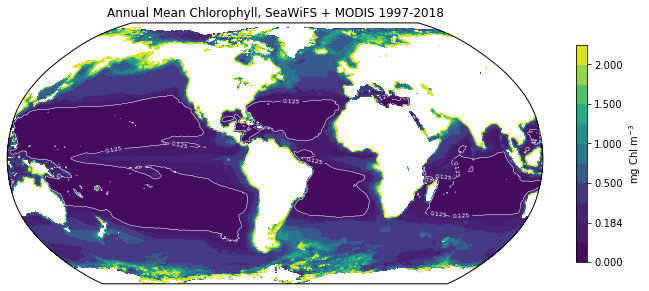

In [16]:
fig = plt.figure(figsize=(12, 8))

lon=obs.lon.values
lat=obs.lat.values
field=obs.chl.mean(dim='time').values
levellbl=[0.125,]
levels=np.sort(np.concatenate((np.array([0.125, np.round(best_thresh,4)]),np.arange(0,2.5,0.25))))


ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=300.0))

# filled contours
cf = ax.contourf(lon, lat, field, levels=levels, transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, field, colors='white', levels=levellbl, linewidths=0.5,
                transform=ccrs.PlateCarree())

# add contour labels
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_ylabel('mg Chl m$^{-3}$')
ax.set_title('Annual Mean Chlorophyll, SeaWiFS + MODIS 1997-2018');


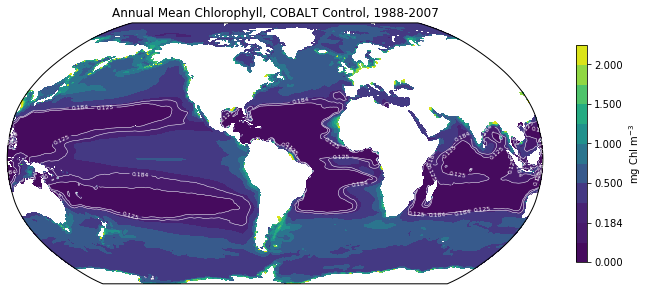

In [17]:
fig = plt.figure(figsize=(12, 8))

lon=grid.geolon.values
lat=grid.geolat.values
field=chl.mean(dim='time').values
levellbl=np.sort(np.array([0.125,np.round(best_thresh,4)]))
levels=np.sort(np.concatenate((np.array(levellbl),np.arange(0,2.5,0.25))))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=300.0))

# filled contours
cf = ax.contourf(lon, lat, field, levels=levels, transform=ccrs.PlateCarree());

# contour lines
cs = ax.contour(lon, lat, field, colors='white', levels=levellbl, linewidths=0.5,
                transform=ccrs.PlateCarree())

# add contour labels
lb = plt.clabel(cs, fontsize=6, inline=True, fmt='%r');

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_ylabel('mg Chl m$^{-3}$')

if 'gz' in short_casename and 'Control' not in short_casename:
    ax.set_title('Annual Mean Chlorophyll, GZ-COBALT, '+pp_dates)
else:
    ax.set_title('Annual Mean Chlorophyll, COBALT Control, '+pp_dates)


filename='plots/'+short_casename+'_'+pp_dates+'_mean_chlorophyll.png'

plt.savefig(filename,dpi=150,bbox_inches='tight')


## Determine Minimum Irradiance at the Mixed Layer

In [18]:
# calculate max mld
max_mld = ds.MLD_003.max(dim='time')
max_mld

<xarray.DataArray 'MLD_003' (yh: 576, xh: 720)>
dask.array<nanmax-aggregate, shape=(576, 720), dtype=float32, chunksize=(576, 720), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89

In [19]:
min_irr_mix = irr_mix.min(dim='time')

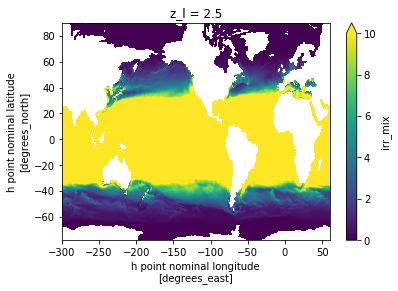

In [20]:
min_irr_mix.plot(vmax=10)

## Set Biomes

In [21]:
#cmap = matplotlib.colors.ListedColormap(["#fc8d62","#8da0cb","#66c2a5"])
cmap = matplotlib.colors.ListedColormap(["#440154FF", "#FDE725FF", "#21908CFF"])
norm = matplotlib.colors.BoundaryNorm([1,2,3,4], cmap.N) 

In [22]:
biomearray=np.empty(chl.mean(dim='time').shape)
biomearray[:]=np.nan

In [23]:
biomearray[np.bitwise_and(np.bitwise_and(chl.mean(dim='time').values <= best_thresh, grid.geolat.values >= -45.), grid.geolat.values < 45.)] = 1 # low chlorophyll
biomearray[np.bitwise_and(biomearray != 1, max_mld.values > 75.)] = 2 # high chlorophyll seasonally stratified
biomearray[np.bitwise_and(biomearray != 1, max_mld.values <= 75.)] = 3 # high chlorophyll permanently stratified

Text(0.5, 1.0, 'Original MLD based biomes')

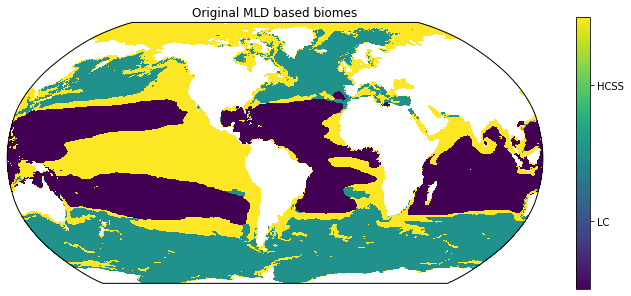

In [24]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))
cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, biomearray, transform=ccrs.PlateCarree())
cbar=plt.colorbar(cs, ticks=[1.5,2.5,3.5])
cbar.ax.set_yticklabels(['LC', 'HCSS', 'HCPS'])

plt.title('Original MLD based biomes')
#figname='plots/'+short_casename+'_'+pp_dates+'_biomes.png'
#plt.savefig(figname,dpi=150,bbox_inches='tight')

In [25]:
biomearray[np.bitwise_and(np.bitwise_and(chl.mean(dim='time').values <= best_thresh, grid.geolat.values >= -45.), grid.geolat.values < 45.)] = 1 # low chlorophyll
biomearray[np.bitwise_and(biomearray != 1, min_irr_mix.values <= 5.)] = 2 # high chlorophyll seasonally stratified
biomearray[np.bitwise_and(biomearray != 1, min_irr_mix.values > 5.)] = 3 # high chlorophyll permanently stratified

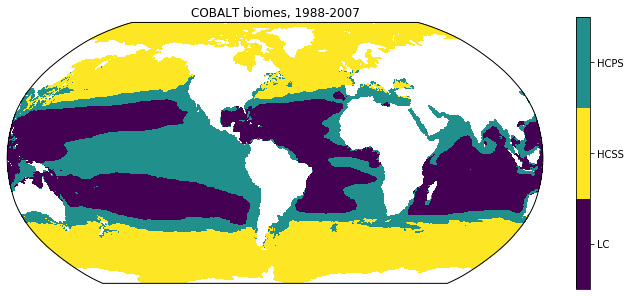

In [26]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=300.0))
cs=ax.pcolormesh(grid.geolon.values, grid.geolat.values, biomearray, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cbar=plt.colorbar(cs, ticks=[1.5,2.5,3.5])
cbar.ax.set_yticklabels(['LC', 'HCSS', 'HCPS'])

if 'gz' in short_casename and 'Control' not in short_casename:
    plt.title('GZ-COBALT biomes, '+pp_dates)
else:
    plt.title('COBALT biomes, '+pp_dates)

figname='plots/'+short_casename+'_'+pp_dates+'_biomes.png'
plt.savefig(figname,dpi=150,bbox_inches='tight')

In [27]:
biomes=xr.DataArray(biomearray, coords={'yh':chl.yh.values, 'xh':chl.xh.values}, dims=['yh','xh'], name='biomes', 
                   attrs={'key':'1-LC; 2-HCSS; 3-HCPS',
                         'chlorophyll-threshold':str(np.round(best_thresh,3))+' mg Chl m^-3'})
biomes

<xarray.DataArray 'biomes' (yh: 576, xh: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
Attributes:
    key:                    1-LC; 2-HCSS; 3-HCPS
    chlorophyll-threshold:  0.184 mg Chl m^-3

In [28]:
biomes = biomes.to_dataset(name='biomes')
biomes

<xarray.Dataset>
Dimensions:  (xh: 720, yh: 576)
Coordinates:
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
Data variables:
    biomes   (yh, xh) float64 nan nan nan nan nan nan ... nan nan nan nan nan

### Save

In [29]:
out_filename = 'biomes/'+short_casename+'_'+pp_dates+'_biomes.nc'

In [30]:
if not os.path.exists(out_filename):
    biomes.to_netcdf(out_filename, mode='w')
    print('Writing File: '+out_filename)
else:
    print('File Exists: '+out_filename)

Writing File: biomes/gzCOBALT-Control-062321_1988-2007_biomes.nc


# Regrid to 1 degree grid

In [31]:
grid_in = grid.drop([v for v in grid if v not in ['geolon','geolat']])
grid_in = grid_in.rename({'geolon':'lon', 'geolat':'lat'})
grid_in

<xarray.Dataset>
Dimensions:  (xh: 720, xq: 720, yh: 576, yq: 576)
Coordinates:
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xq       (xq) float64 -299.5 -299.0 -298.5 -298.0 ... 58.5 59.0 59.5 60.0
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yq       (yq) float64 -77.82 -77.63 -77.45 -77.26 ... 89.37 89.58 89.79 90.0
Data variables:
    lat      (yh, xh) float32 -77.91 -77.91 -77.91 -77.91 ... 65.39 65.18 64.97
    lon      (yh, xh) float32 -299.8 -299.2 -298.8 -298.2 ... 59.99 59.99 60.0
Attributes:
    external_variables:  areacello areacello

In [32]:
grid_out = xr.Dataset({'lat': (['lat'], np.arange(89.5, -90, -1)),
                     'lon': (['lon'], np.arange(-299.5, 60, 1))})
grid_out

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float64 -299.5 -298.5 -297.5 -296.5 ... 56.5 57.5 58.5 59.5
Data variables:
    *empty*

In [33]:
import xesmf as xe

regridder = xe.Regridder(grid_in, grid_out, 'bilinear', reuse_weights=True, periodic=True)

# regrid
da_out = regridder(biomes.biomes)

da_out

Reuse existing file: bilinear_576x720_180x360_peri.nc


<xarray.DataArray 'biomes' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan,  2., ...,  2., nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -299.5 -298.5 -297.5 -296.5 ... 56.5 57.5 58.5 59.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Attributes:
    regrid_method:  bilinear

In [34]:
da_rolled = da_out.roll(lon=-120, roll_coords=True)
da_rolled

<xarray.DataArray 'biomes' (lat: 180, lon: 360)>
array([[ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... -182.5 -181.5 -180.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Attributes:
    regrid_method:  bilinear

In [35]:
biomes_x1 = xr.DataArray(data=da_rolled.values, coords={'lat':da_rolled.lat.values,
                                                        'lon':np.arange(-179.5, 180, 1)}, dims=['lat','lon'])
biomes_x1 = biomes_x1.to_dataset(name='biomes')

In [36]:
biomes_x1

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    biomes   (lat, lon) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... nan nan nan nan nan

### Save

In [37]:
out_filename = 'biomes/'+short_casename+'_'+pp_dates+'_biomes_x1.nc'

In [38]:
if not os.path.exists(out_filename):
    biomes_x1.to_netcdf(out_filename, mode='w')
    print('Writing File: '+out_filename)
else:
    print('File Exists: '+out_filename)

Writing File: biomes/gzCOBALT-Control-062321_1988-2007_biomes_x1.nc
